In [1]:
import networkx as nx
from datetime import datetime
import numpy as np
import random
import tqdm as tqdm
import pandas as pd
from Barinel import *
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

#### Read file and extract time stamp

In [2]:
def extract_time(lines):
    # remove all lines until timestamp line, and return time stamp (tuple of integers)
    for line in lines:
        
        # pop first line and split
        line_content = txt.pop(0).split('\t')
        
        # stop when timestamp line is found
        if line_content[0] == 'T':
            
            time_stamp = (int(line_content[1]) , int(line_content[2].strip('\n')))
            break
            
    return time_stamp

In [3]:
def tup_stmp_to_dates(tup):
    return [datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') for x in tup]

---

In [4]:
# enter a path for as links file from CAIDA.
# these files could be found in:
# http://data.caida.org/datasets/topology/ark/ipv4/as-links/team-1/2019/cycle-aslinks.l7.t1.c007532.20190629.txt.gz
file_path = 'cycle-aslinks.l7.t1.c007532.20190629.txt'

In [5]:
with open(file_path, 'r') as file:
    txt = file.readlines()[:]
time_stamp = tup_stmp_to_dates(extract_time(txt))
print('File recording times: {} - {}'.format(time_stamp[0], time_stamp[1]))

File recording times: 2019-06-29 07:15:01 - 2019-06-30 03:46:00


#### Read file, create the graph, and extract largest connected component

In [6]:
direct_links = [] # (from, to) tuples key

# extract all edges
for i, line in enumerate(txt):
    if i < 5000:
        l = line.strip("\n").split("\t")
        typ = l.pop(0)
        if typ == 'D':
            direct_links.append((l[0], l[1]))

# subsample 2000
direct_links = random.sample(direct_links, 2000)
g = nx.Graph()
g.add_edges_from(direct_links)

In [7]:
max_conn_comp = max([g.subgraph(c) for c in nx.connected_components(g)], key = lambda x: len(x.nodes))
print(f'org_graph: num. nodes: {len(g.nodes())} ;   num. edges: {len(g.edges())}')
print(f'conn_comp: num. nodes: {len(max_conn_comp.nodes())} ;   num. edges: {len(max_conn_comp.edges())}')

org_graph: num. nodes: 1883 ;   num. edges: 1988
conn_comp: num. nodes: 1536 ;   num. edges: 1737


#### random error injection

In [8]:
#mu, sigma = -0.6, 0.87 # mean and standard deviation. numbers for 10% error
mu, sigma = -0.5,0.62 # mean and standard deviation. numbers for 5% error

# random error addition according to distribution
s = (np.random.normal(mu, sigma, len(max_conn_comp.nodes())))

# clipping between 0.5 and 2
s[np.where(s<0.5)]=0
s[np.where(s>2)]=2

print(f'Normal components: {len(s[np.where(s==0)])} ;   Abnormal components: {len(s[np.where(s!=0)])}')

Normal components: 1448 ;   Abnormal components: 88


In [9]:
# setting node latency as node attribute
node_weights = {node: {'latency': lat} for node, lat in zip(max_conn_comp.nodes(), s)}
nx.set_node_attributes(max_conn_comp, node_weights)

# create a global dictionary to hild latency
latency = nx.get_node_attributes(max_conn_comp, 'latency')

#### save the graph for external use

In [10]:
nx.write_gml(max_conn_comp, 'internet.gml')

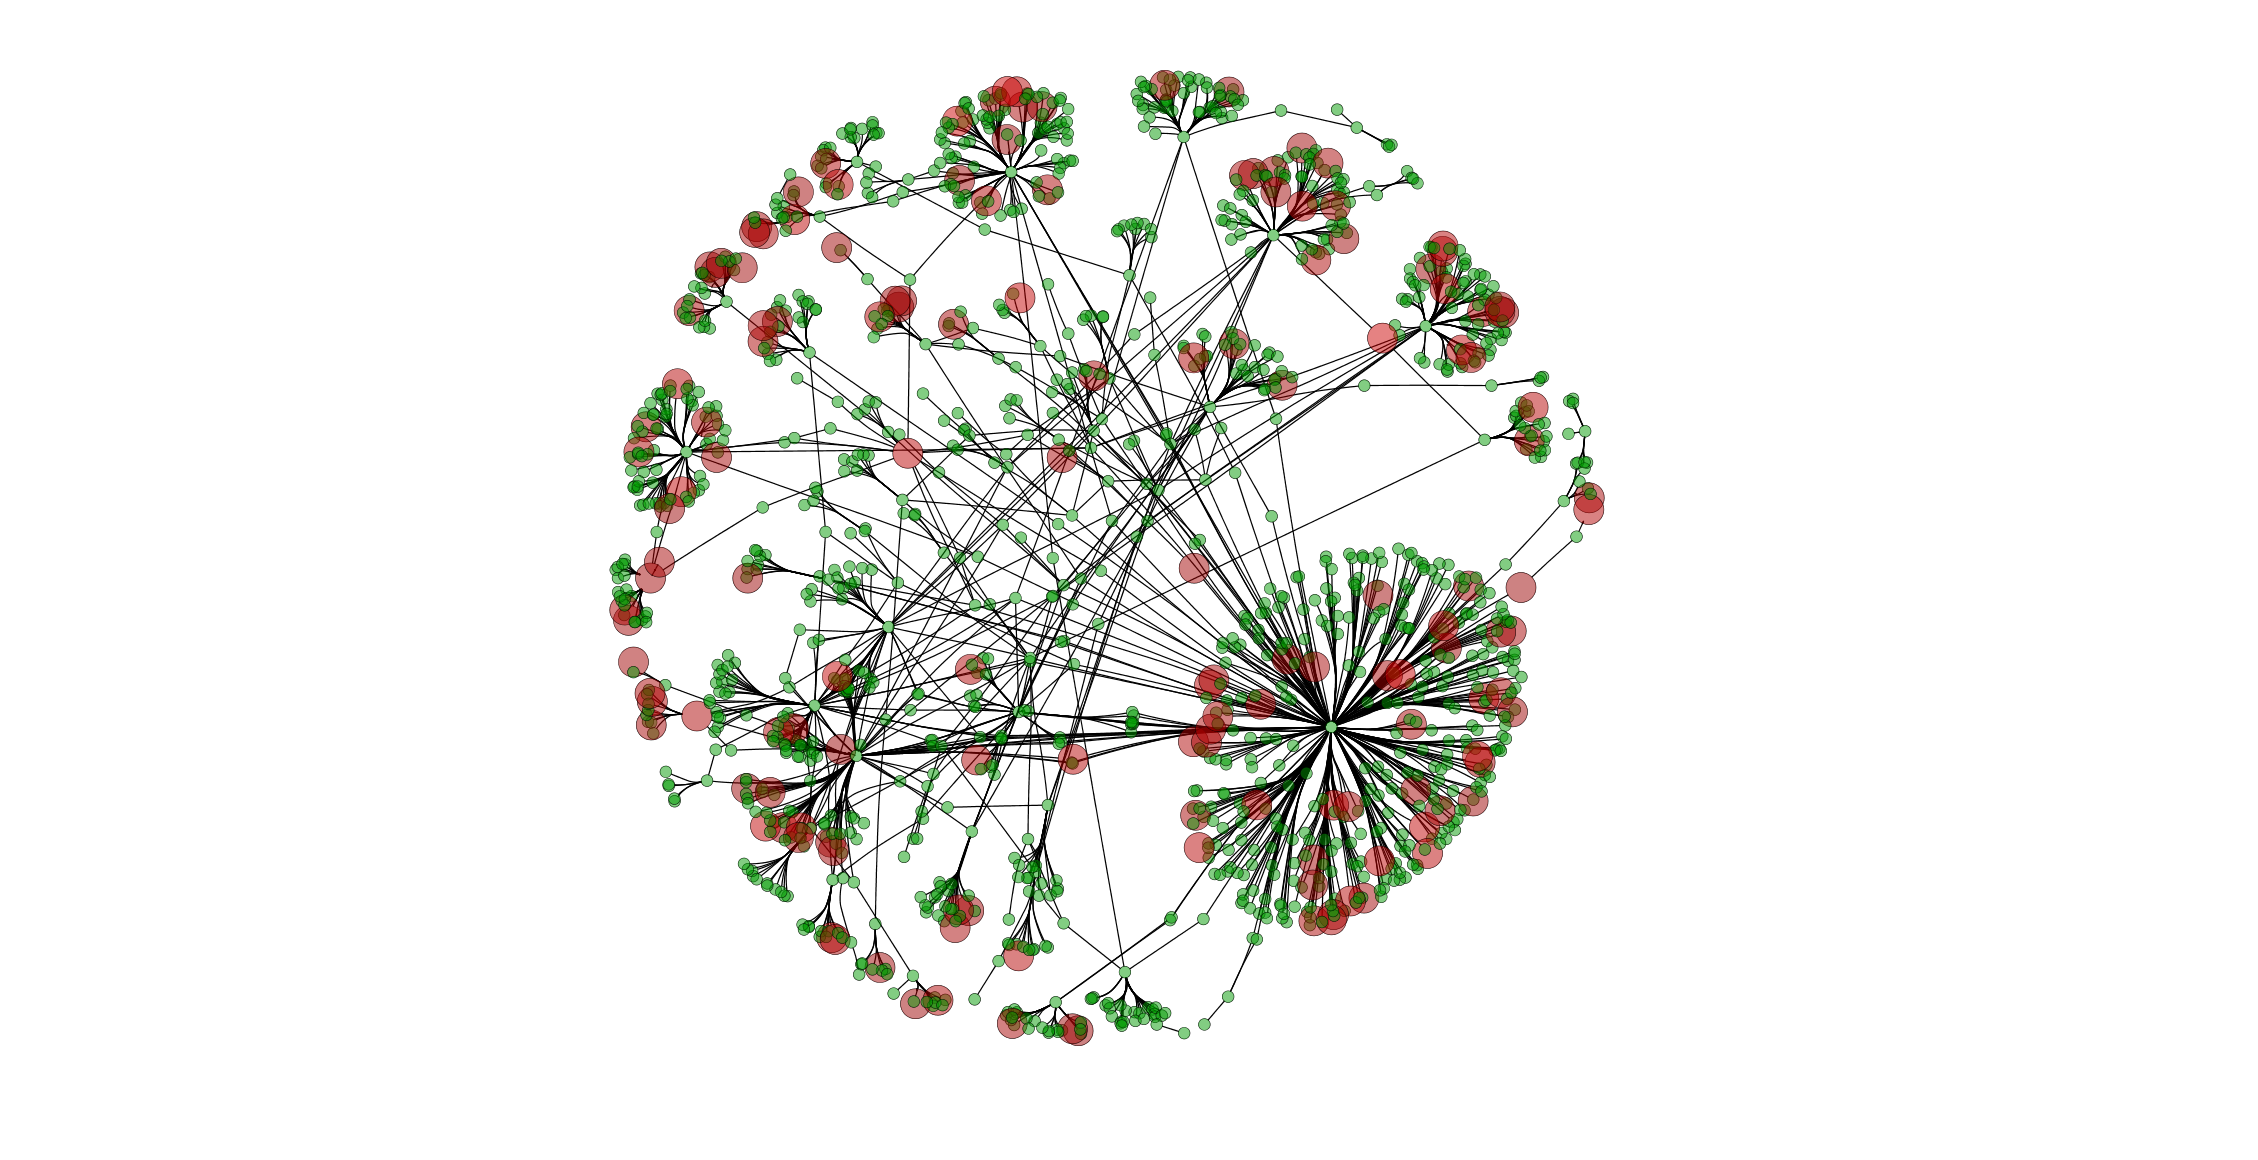

In [11]:
Image(filename='2000_nodes.png') 

#### random subgraph generation

In [12]:
def sort_by_degree(graph, reverse=True):
    # sort nodes by degree
    return sorted(list(graph.degree()), key = lambda x: x[1], reverse=reverse)

In [13]:
def choose_random_main_nodes(node_list, top_k_degree, num_choices):
    return random.sample([x[0] for x in node_list[:top_k_degree]], num_choices)

In [14]:
def generate_sub_graph(connected_component, top_k_degree=10, num_choices=4, num_end_nodes=2):
    
    # sort nodes by degree
    deg_list = sort_by_degree(connected_component)

    # sample nodes from most central nodes
    sub_graph_main_nodes = choose_random_main_nodes(deg_list, top_k_degree, num_choices)

    # extend nodes selection by a-star paths between important nodes
    connecting_nodes = []
    for n_1 in sub_graph_main_nodes:
        for n_2 in sub_graph_main_nodes:
            if n_1 == n_2:
                continue
            connecting_nodes += nx.astar_path(max_conn_comp, n_1, n_2)

    # extend nodes selection by choosing 2 random nodes which are connected to main nodes
    end_nodes = []
    for n in sub_graph_main_nodes:
        end_nodes += random.sample(list(max_conn_comp[n]),num_end_nodes)

    # putting it all together
    sub_graph_nodes = set(sub_graph_main_nodes + connecting_nodes + end_nodes)
    
    return connected_component.subgraph(sub_graph_nodes)

---

In [15]:
g_1 = generate_sub_graph(max_conn_comp, 10, 3, 4)

In [16]:
nx.draw(g_1)

In [17]:
print(f'Unique components: {len(g_1.nodes)} ;   Abnormal components: {[node for node in g_1.nodes if latency[node]>0]}')

Unique components: 18 ;   Abnormal components: ['25916', '12097']


In [18]:
nx.write_gml(g_1, 'internet_small.gml')

#### create data

In [19]:
def generate_random_paths(graph, num_paths):
    # choose num_paths random paths from graph
    return random.sample([nx.astar_path(graph, n_1, n_2) for n_1 in graph for n_2 in graph if n_1!=n_2], num_paths)

In [20]:
def path_weight(graph, path):
    # calculate accumlated latency for each path
    latency = nx.get_node_attributes(graph, 'latency')
    return sum([latency[node] for node in path])

In [21]:
def spectrum_matrix(paths):
    # set of all components invloved in all paths
    all_nodes = list({comp for path in paths for comp in path})
    
    # instantiate a spectral matrix
    spectra = np.zeros((len(paths), len(all_nodes)), dtype=np.int8)
    
    # mark 1 in all matrix entries where comp (column) participated in path (row)
    for row, path in enumerate(paths):
        for comp in path:
            spectra[row, all_nodes.index(comp)] = 1
            
    return spectra, all_nodes

In [22]:
def error_standartize(vector, upper=1, lower=0.2):
    indices = np.where(vector>0)
    max_er = np.max(vector[indices])
    min_er = np.min(vector[indices])
    output =(vector - min_er)/(max_er - min_er) * (upper-lower) +lower
    output[np.where(output<0)]=0
    return output

In [23]:
def comps_summary(unique_comps):
    unique_comps_map = {f'c{i+1}': {'comp': comp, 'latency': latency[comp]} for i, comp in enumerate(unique_comps)}
    erroneous_comps = [item[0] for item in unique_comps_map.items()  if item[1]['latency']>0]
    return len(unique_comps_map), unique_comps_map, len(erroneous_comps), erroneous_comps

In [24]:
def generate_all_paths(graph, remove_obvious=False):
    erroneous_nodes = set([node for node in g_1.nodes if latency[node]>0])
    num_erroneous = len(erroneous_nodes)
    
    paths = []
    for n_1 in graph:
        for n_2 in graph:
            if n_1 == n_2:
                continue
            paths += nx.all_simple_paths(graph, n_1, n_2)
            
    # remove paths which contain all erroneous components (which is the easy solution)
    if remove_obvious:
        paths = [path for path in paths if not erroneous_nodes.issubset(set(path))]        
    return paths 

#### evaluation

In [25]:
def crispify(vec, thresh):
    # return a vector of 0's and 1's, determined by crisp threshold
    crisp_error_vec = np.zeros(vec.shape)
    crisp_error_vec[np.where(vec>=thresh)[0]] = 1
    return crisp_error_vec

In [26]:
def crisp_barinel_diagnoses(mat, vec, stac_diags, thresholds, verbose=False):
    crisp_error_vectors, ranked_diagnoses = [], []
    diagnoses_output = []
    
    for thresh in thresholds:
        
        crisp_error_vec = crispify(vec, thresh)
        ranked_diags = barinel(mat, crisp_error_vec, stac_diags)
        
        crisp_error_vectors.append(crisp_error_vec)  # used to build matrix again. mainly for development
        
        ranked_diags = [diag[0] for diag in ranked_diags]  # remove probabilites
        ranked_diagnoses.append(ranked_diags)
        
        if verbose:
            print(f'Threshold {thresh}:')
            print(ranked_diags[:5])
            
    return crisp_error_vectors, ranked_diagnoses

In [27]:
all_paths = generate_all_paths(g_1, remove_obvious=True)

In [28]:
threshes = [0.2, 0.4, 0.6, 0.8, 1.0]

In [30]:
res = []
i=0

# evaluate over 50 random selections of paths within the dataset. it might take a few minutes
while i < 10:
    # generate 10 paths, and spectra matrix
    paths = random.sample(all_paths, 10)
    mat, unique_comps = spectrum_matrix(paths)

    # generate error vector
    path_weights = [path_weight(g_1, path) for path in paths]
    error = np.array(path_weights).reshape(-1,1)
    vec = error_standartize(error).reshape(-1,1)

    num_unique, unique_comps_map ,num_err, erroneous_comps = comps_summary(unique_comps)
    erroneous_comps_for_eval = tuple(int(c[1:])-1 for c in erroneous_comps)  # create a tuple of correct diagnosis
    
    stac_diags = staccato(mat, vec)

    fuzzy_ranked_diags = barinel(mat, vec, stac_diags)
    fuzzy_ranked_diags_for_eval = [diag[0] for diag in fuzzy_ranked_diags]
    
    # rank diagnoses with crisp thresholds
    _, ranked_diagnoses = crisp_barinel_diagnoses(mat, vec, stac_diags, thresholds = threshes, verbose=False)
    
    # concat fuzzy and crisp barniel results to one list
    ranked_diagnoses = [fuzzy_ranked_diags_for_eval] + ranked_diagnoses
    
    # compute wasted error
    try:
        res.append(np.array([rd.index(erroneous_comps_for_eval) for rd in ranked_diagnoses]))
        i+=1
    except:
        pass

In [31]:
# calculate and print average wasted effort
print([(i[0]) for i in np.mean(res, axis=0).reshape(-1,1)])

[16.8, 1.5, 1.5, 1.5, 1.5, 1.5]
